#**Graded Challenge 3 Phase 1**
## **Heart Failure Prediction based on Ensamble Classifier: Random Forest Classifier and Adaptive Boost Classifier**

Nadia Oktiarsy, FSDS Batch-016 RMT (Buddy: Dian)

---
```
Table of Contents:
1. Introduction
2. Importing Libraries
3. Data Loading
4. Exploratory Data Analysis (EDA)
5. Data Preprocessing
6. Model Definition
7. Model Training
8. Model Evalutation
9. Model Inference
10. Conclusion
```

## **1. Introduction**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### **Problem Statements**

Since there are many features that can influence the mortaility by heart failute, this analysis will **determine whether a patient will have a heart attack or not**, because of the suspected variables.

The analysis will use Ensamble Classifier: **Random Forest Classifier (RF)** and **Adaptive Boost Classifier (ABC)**. From those two algorithm, there will be an analysis for comparing the classification model and how it suggests the result of heart failure classification.

## **2. Importing Libraries**

In [170]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import sys
import sklearn

import warnings
warnings.filterwarnings('ignore')

# Data visualization libraries
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,8)

from sklearn import tree

# Feature Selection
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# import Ensamble classifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Evaluate Classification Models
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# GoogleCloud Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

# Save and Load Model
import joblib
import json

project = 'hacktiv8-016-nadiaoktiarsy' # Project ID inserted based on the query results selected to explore
location = 'US'                        # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
auth.authenticate_user()

## **3. Data Loading**

The data available has `299 rows` and `13 columns`.

In [96]:
# Creating query
df = client.query('''
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_016_rmt.heart-failure`
''').to_dataframe()

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,42.0,1,250,1,15,0,213000.0,1.3,136,0,0,65,1
1,46.0,0,168,1,17,1,271000.0,2.1,124,0,0,100,1
2,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
3,53.0,1,91,0,20,1,418000.0,1.4,139,0,0,43,1
4,50.0,1,582,1,20,1,279000.0,1.0,134,0,0,186,0


In [97]:
df.tail()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
294,63.0,1,122,1,60,0,267000.00,1.2,145,1,0,147,0
295,45.0,0,308,1,60,1,377000.00,1.0,136,1,0,186,0
296,70.0,0,97,0,60,1,220000.00,0.9,138,1,0,186,0
297,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0
298,50.0,0,582,0,62,1,147000.00,0.8,140,1,1,192,0


In [98]:
## Downloading csv file
# from google.colab import files
# df.to_csv(r'h8dsft_P1G3_nadia_oktiarsy.csv')
# files.download(r'h8dsft_P1G3_nadia_oktiarsy.csv')

Based on the data information, it can be found that all data are mostly intergers. Then we convert the data from interger to float so it will be easier to scale later.

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    Int64  
 2   creatinine_phosphokinase  299 non-null    Int64  
 3   diabetes                  299 non-null    Int64  
 4   ejection_fraction         299 non-null    Int64  
 5   high_blood_pressure       299 non-null    Int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    Int64  
 9   sex                       299 non-null    Int64  
 10  smoking                   299 non-null    Int64  
 11  time                      299 non-null    Int64  
 12  DEATH_EVENT               299 non-null    Int64  
dtypes: Int64(10), float64(3)
memory usage: 33.4 KB


In [100]:
# Converting all columsn from int to float
df = df.rename(columns={'DEATH_EVENT':"death_event"})
df = df.astype({'age':'float','anaemia':'float','creatinine_phosphokinase':'float','diabetes':'float','ejection_fraction':'float',
                'high_blood_pressure':'float','platelets':'float','serum_creatinine':'float','serum_sodium':'float','sex':'float',
                'smoking':'float','time':'float','death_event':'float'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    float64
 2   creatinine_phosphokinase  299 non-null    float64
 3   diabetes                  299 non-null    float64
 4   ejection_fraction         299 non-null    float64
 5   high_blood_pressure       299 non-null    float64
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    float64
 9   sex                       299 non-null    float64
 10  smoking                   299 non-null    float64
 11  time                      299 non-null    float64
 12  death_event               299 non-null    float64
dtypes: float64(13)
memory usage: 30.5 KB


In [101]:
# Checking missing values
df.isnull().sum().sum()

0

**Data description**

Header | Definition
---|---
`age` | Age in years
`anemia` | Decrease of red blood cells or hemoglobin (0 = no anaemia, 1 = has anaemia)
`creatinine_phosphokinase  ` | Level of the CPK enzyme in the blood (mcg/L)
`diabetes` | If the patient has diabetes (0 = no diabetes, 1 = has diabetes)
`ejection_fraction` | Percentage of blood leaving the heart at each contraction (percentage)
`high_blood_pressure` | If the patient has hypertension (0 = no, 1 = yes)
`platelets` | Platelets in the blood (kiloplatelets/mL)
`serum_creatinine` | Level of serum creatinine in the blood (mg/dL)
`serum_sodium` | Level of serum sodium in the blood (mEq/L)
`sex` | Woman or man (Female = 0, Male = 1)
`smoking` | If the patient smokes or not (0 = no, 1 = yes)
`time` | Follow-up period (days)
`DEATH_EVENT` | If the patient deceased during the follow-up period (0 = no, 1= yes)

## **4. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis will be divided into two:
1. General Information, to describe the `Death Event` with other variables in general.
2. Correlation Analysis, to describe deeper between `Death Event` and other variables through correlation analysis.

### **4.1. General Information**

In [186]:
# General statistic information
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


**Number of Death Event**

Number of deaths after the following days are different, where `Non-Death` is higher 35% from `Death`. This will be keep in mind if there is any imbalance data or not. But first, the `death_event`--as the target--will be compared with other variables so we can get the conclusion for the skewness and handling imbalance data.

In [113]:
# Number of Death Event
df.death_event.value_counts()

0.0    203
1.0     96
Name: death_event, dtype: int64

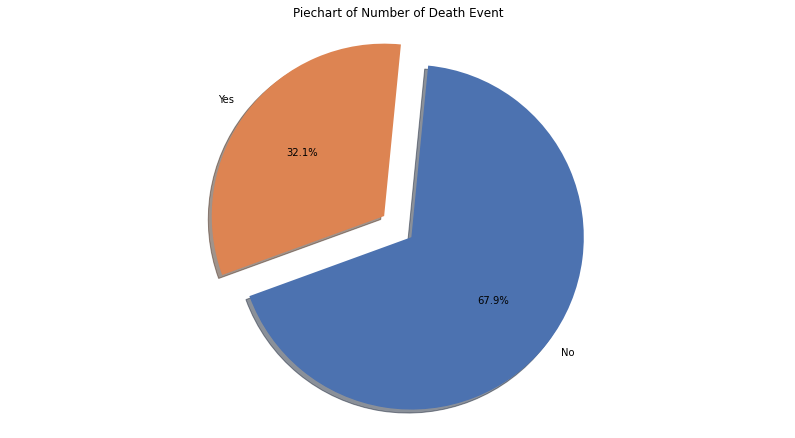

In [114]:
# Creating Plot piechart of Cab Type (Uber vs Lyft)
num_death = dict(df.death_event.value_counts())
labels = 'No', 'Yes'
sizes = [num_death[0], num_death[1]]
explode = (0, 0.2)

with sns.color_palette("deep"):
    plt.pie(sizes, explode=explode, labels=labels,
    autopct='%1.1f%%', shadow=True, startangle=200)

# Plot title
plt.axis('equal')
plt.title('Piechart of Number of Death Event')
plt.show()

**Gender Distribution**

There is no significant difference between female and male for having death_event. It also can be seen that the average age for both female and male are around 60 years old. It is suspected that `sex` does not have any strong influence to `death_event`.

Text(0.5, 1.0, 'Barplot of Chance of Heart Attack based on Age')

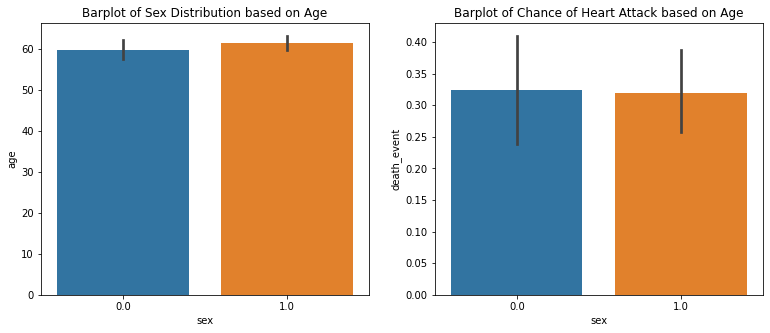

In [115]:
matplotlib.rcParams['figure.figsize'] = (20,5)

# Plotting Gender Distribution
plt.subplot(1, 3, 1)
sns.barplot(data=df, x='sex', y='age')
plt.title('Barplot of Sex Distribution based on Age')

# Plotting Education level Distribution
plt.subplot(1, 3, 2)
sns.barplot(data=df, x='sex', y='death_event')
plt.title('Barplot of Chance of Heart Attack based on Age')

**Comparison between Death Event with other variables**

Based on the histogram below, we can see that the distribution of Not Death is still dominating that Death. However, we should check wherer variable *time* looks different than the others, where Death is high with time between 0-100 days. from here we should check the skewness of *time* as well.

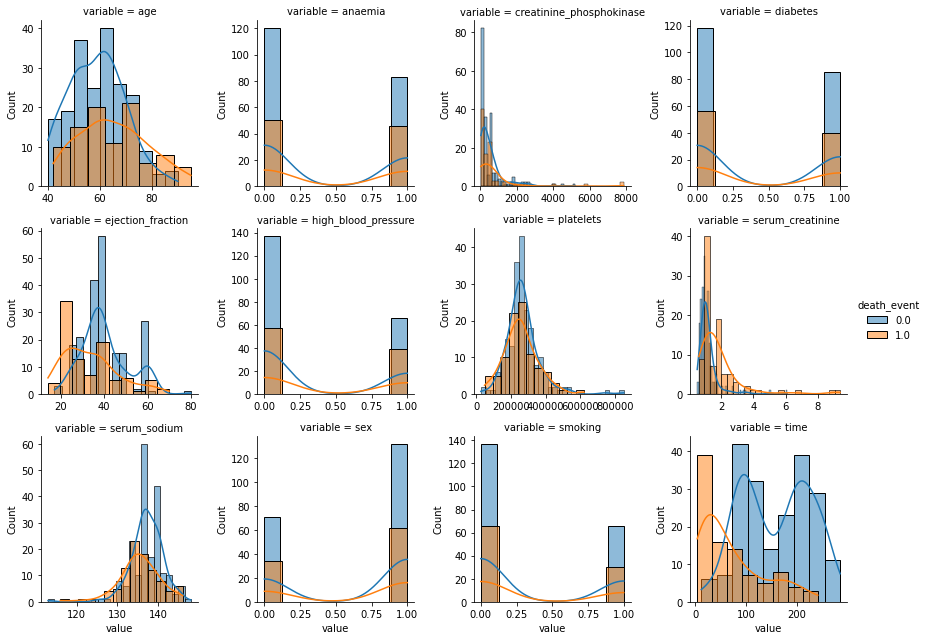

In [116]:
# Creating new dataframe for the histogram
output = 'death_event'
cols = [f for f in df.columns if df.dtypes[f] != "object"]
f = pd.melt(df, id_vars=output, value_vars=cols)

# Creating histogram
g = sns.FacetGrid(f, hue=output, col="variable", col_wrap=4, sharex=False, sharey=False )
g = g.map(sns.histplot, "value", kde=True).add_legend()

### **4.2. Correlation Analysis**

Since the data all in intergers, the data for correlation analysis will be handled by creating its scaling and encoding.

In [118]:
# Splitting between numerical columns and categorical columns
num_columns = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
cat_columns = ['anaemia','diabetes','high_blood_pressure','sex','smoking','death_event']

print('Numerical columns  : ', num_columns)
print('Categorical columns  : ', cat_columns)

Numerical columns  :  ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
Categorical columns  :  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']


In [119]:
# Making feature scaling for numerical columns with Normalizaation - MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)

df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
df_scaled

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,0.036364,1.0,0.028961,1.0,0.015152,0.0,0.227785,0.089888,0.657143,0.0,0.0,0.217082,1.0
1,0.109091,0.0,0.018500,1.0,0.045455,1.0,0.298097,0.179775,0.314286,0.0,0.0,0.341637,1.0
2,0.454545,1.0,0.017479,1.0,0.090909,0.0,0.365984,0.247191,0.085714,0.0,0.0,0.014235,1.0
3,0.236364,1.0,0.008676,0.0,0.090909,1.0,0.476300,0.101124,0.742857,0.0,0.0,0.138790,1.0
4,0.181818,1.0,0.071319,1.0,0.090909,1.0,0.307795,0.056180,0.600000,0.0,0.0,0.647687,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.418182,1.0,0.012631,1.0,0.696970,0.0,0.293248,0.078652,0.914286,1.0,0.0,0.508897,0.0
295,0.090909,0.0,0.036361,1.0,0.696970,1.0,0.426597,0.056180,0.657143,1.0,0.0,0.647687,0.0
296,0.545455,0.0,0.009441,0.0,0.696970,1.0,0.236271,0.044944,0.714286,1.0,0.0,0.647687,0.0
297,0.236364,1.0,0.053968,0.0,0.696970,1.0,0.288833,0.056180,0.742857,1.0,0.0,0.750890,0.0


Based on the correlation, `time` is the strongest correlation with death event, and the relationship is negative correlation. This means that heart attack kills people who got it within short following-up days after the heart attack event.

Moreover, `age` and `serum_creatine` have a positive correlation although not as strong as *time*. For age, this means that the older the person, the higher chance they have `death` from the heart attack. Serum creatine means the higher level of serum creatine in blood, the higher chance this person will die from the heart attack.

Meanwhile, `sex` and `diabetes` are the lowest correlation overall. `Smoking` and `platelets ` are also low, but not as long as sex and diabetes, so we should evaluate furthermore for these two varibles.

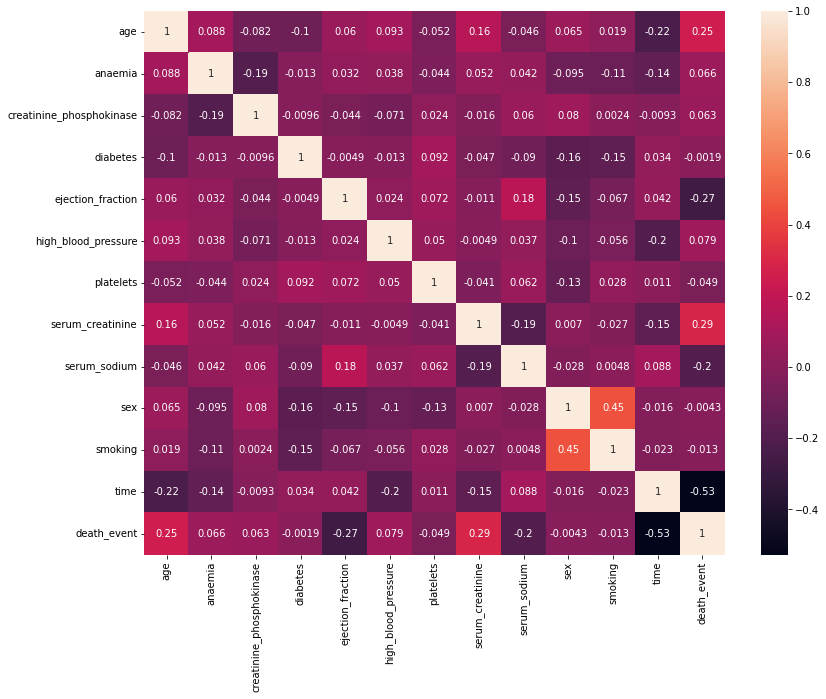

In [120]:
# Plotting Correlation Matrix of Categorical columns and Price
plt.figure(figsize=(13,10))
sns.heatmap(df_scaled.corr(),annot=True)

### **4.3. Chi-square**

After evaluating from chi-square, as the threshold is set 5% (or p-value is 0.05), it can be observed that `time`, `serum_creatine`, and `age` hold top three highest significance. Meanwhile the lowest are `sex`, `diabetes`, `smoking`, and `platelets` are under p-value 0.05 threshold, which are not significant to influence the `death_event`.

Thus we can see that both correlation and chi-square analysis can prove the same significance.

In [121]:
X_chi = df_scaled.drop(['death_event'],axis=1)
y_chi = pd.DataFrame(df_scaled['death_event'])

# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
train = SelectKBest(score_func=chi2, k=4)
fit = train.fit(X_chi, y_chi)

chi = pd.Series(fit.scores_)
chi.index = X_chi.columns
chi.sort_values(ascending=False)

time                        14.050286
serum_creatinine             3.471610
age                          2.368846
ejection_fraction            1.894516
high_blood_pressure          1.221539
anaemia                      0.746593
serum_sodium                 0.267368
creatinine_phosphokinase     0.252029
platelets                    0.035021
smoking                      0.032347
sex                          0.001956
diabetes                     0.000657
dtype: float64

## **5. Data Preprocessing**

Exploratory Data Analysis shows that there are four variables that should be dropped because of their low correlation and significance: `diabetes`, `sex`, `smoking`, and `platelets`.

In [122]:
# Drop target from features table, and from selection analysis
df_final = df.drop(['diabetes', 'sex', 'smoking', 'platelets'],axis=1)

### **5.1. Data Inference**

In [123]:
# Creating data inference
df_inf = df_final.sample(10, random_state=32).sort_index()
df_inf

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time,death_event
19,57.0,1.0,129.0,30.0,0.0,1.00,140.0,42.0,1.0
103,54.0,1.0,427.0,70.0,1.0,9.00,137.0,196.0,1.0
109,65.0,0.0,146.0,20.0,0.0,1.30,129.0,7.0,1.0
115,60.0,0.0,68.0,20.0,0.0,2.90,127.0,64.0,1.0
123,62.0,0.0,231.0,25.0,1.0,0.90,140.0,10.0,1.0
204,63.0,1.0,103.0,35.0,0.0,0.90,136.0,270.0,0.0
242,55.0,0.0,835.0,40.0,0.0,0.70,140.0,147.0,0.0
264,55.0,1.0,180.0,45.0,0.0,1.18,137.0,211.0,0.0
285,85.0,0.0,129.0,60.0,0.0,1.20,132.0,90.0,1.0
296,70.0,0.0,97.0,60.0,1.0,0.90,138.0,186.0,0.0


In [124]:
# Drop data inference as a new dataframe
df_train_test = df_final.drop(df_inf.index)
df_train_test

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time,death_event
0,42.0,1.0,250.0,15.0,0.0,1.3,136.0,65.0,1.0
1,46.0,0.0,168.0,17.0,1.0,2.1,124.0,100.0,1.0
2,65.0,1.0,160.0,20.0,0.0,2.7,116.0,8.0,1.0
3,53.0,1.0,91.0,20.0,1.0,1.4,139.0,43.0,1.0
4,50.0,1.0,582.0,20.0,1.0,1.0,134.0,186.0,0.0
...,...,...,...,...,...,...,...,...,...
293,60.0,1.0,95.0,60.0,0.0,1.0,138.0,146.0,0.0
294,63.0,1.0,122.0,60.0,0.0,1.2,145.0,147.0,0.0
295,45.0,0.0,308.0,60.0,1.0,1.0,136.0,186.0,0.0
297,53.0,1.0,446.0,60.0,1.0,1.0,139.0,215.0,0.0


### **5.2. Train and Test Set**

In [125]:
# Defining X and y
X = df_train_test.drop(['death_event'],axis=1)
y = pd.DataFrame(df_train_test['death_event'])
X.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time
0,42.0,1.0,250.0,15.0,0.0,1.3,136.0,65.0
1,46.0,0.0,168.0,17.0,1.0,2.1,124.0,100.0
2,65.0,1.0,160.0,20.0,0.0,2.7,116.0,8.0
3,53.0,1.0,91.0,20.0,1.0,1.4,139.0,43.0
4,50.0,1.0,582.0,20.0,1.0,1.0,134.0,186.0


In [126]:
# Seperating dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=3)

print('Train size : ', X_train.shape)
print('Test size. : ', X_test.shape)

Train size :  (202, 8)
Test size. :  (87, 8)


### **5.3. Data Skewness**

Based on the skewness of the data, we can find that both Train set and Test set are `Normal Distribution`. This will be useful for outliers later. The data that will be taken to describe the data skewness is from `time`.

As the result:
```
'time' skewness: 0.1708108697516051
Normal Distribution
```

In [127]:
# Creating a function to print the skewness
def print_skewness(data):
    print(f'\'{data.name}\' skewness: {data.skew()}')
    # print(f'\'{data.name}\'kurtosis: {data.kurt()}')
    if data.skew() > 0.5:
        print ('Right skewed')
    elif data.skew() < -0.5:
        print( 'Left Skewed')
    else:
        print("Normal Distribution")

# Creating a function to visualize the data
def visualize_data(data):
    print_skewness(data)
    plt.hist(data, bins=65, rwidth=1, density=True)
    plt.xlabel(f'{data.name}')
    plt.ylabel('Probability Density')
    rng = np.arange(data.min(), data.max(), 0.1)
    plt.plot(rng, norm.pdf(rng,data.mean(),data.std()))

    # label the plot
    plt.legend(['Normal PDF(Probability Density Function) ', 'Histogram: Load Weight'])
    plt.axvline(data.mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(data.median(), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(data.mode()[0], color='red', linestyle='dashed', linewidth=2)
    plt.show()

'time' skewness: 0.1708108697516051
Normal Distribution


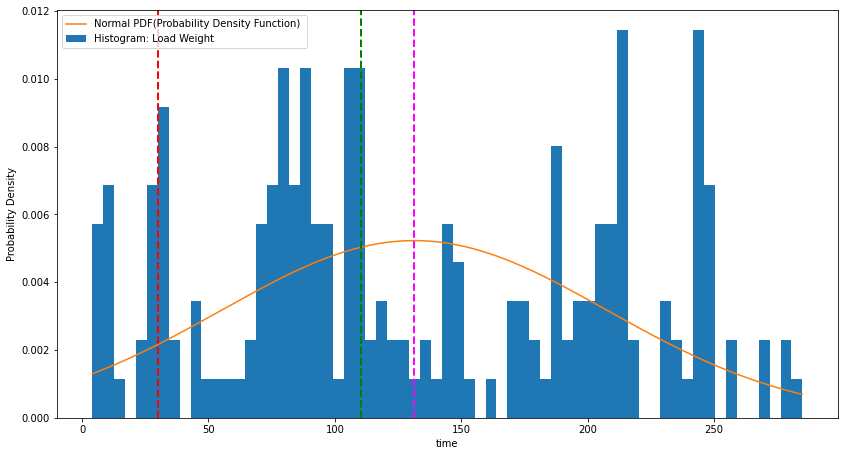

In [128]:
# Visualizing skewed data for X_train
visualize_data(X_train.time)

### **5.4. Outliers**

Based on the comparison of boxplots between top three highest correlation and significance, `time` and `age` are Normal Distribution, meanwhile `serum_creatinine` is skewed. However, since the number of data is too little, then it is decided that the distribution of the overall data is Normal Distribution.

There is no outlier since the skewness of the data is normal. We can observe that the histogram above is the same with the the boxlplot below. Moreover, we can see from the outliers analysis that the upper and inner limit is 360.4 and -97. Since it is the variable `time`, then the value should be more than 0 (or positive).

Text(0, 0.5, 'serum_creatinine')

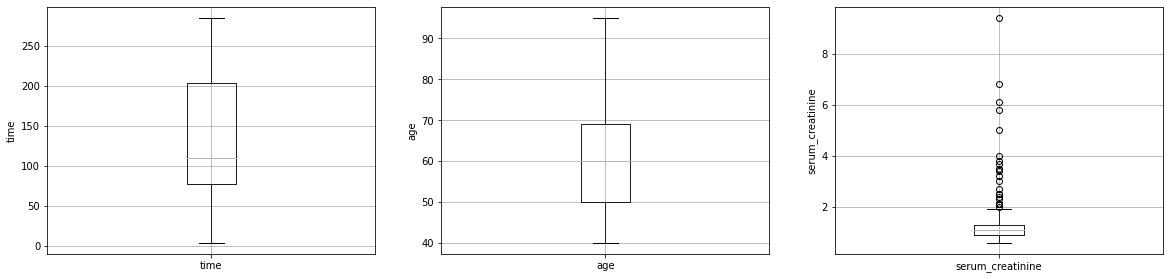

In [190]:
# Draw boxplots to visualize outliers

plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
fig1 = X_train.boxplot(column='time')
fig1.set_title('')
fig1.set_ylabel('time')

plt.subplot(2, 3, 2)
fig2 = X_train.boxplot(column='age')
fig2.set_title('')
fig2.set_ylabel('age')

plt.subplot(2, 3, 3)
fig3 = X_train.boxplot(column='serum_creatinine')
fig3.set_title('')
fig3.set_ylabel('serum_creatinine')

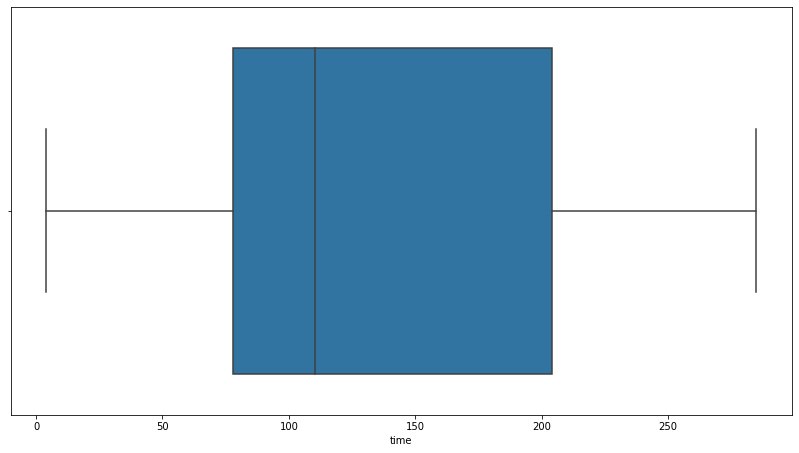

In [129]:
# Checking boxplot after removing outliers
sns.boxplot(x = X_train['time'])
plt.show()

In [130]:
# Determining upper and lower limit
upper = X_train['time'].mean() + 3*X_train['time'].std()
lower = X_train['time'].mean() - 3*X_train['time'].std()

print("Upper limit: ", upper)
print("Lower limit: ", lower)

Upper limit:  360.3952233587827
Lower limit:  -97.58334217066388


In [131]:
# Checking the outliers
X_train[(X_train['time'] > upper) | (X_train['time'] < lower)]

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time


This should be taken notes that Ensamble Learning is strongly influence by outliers. However, since the number of data is little, then the outliers here will be acted as natural outliers.

### **5.5. Features Selection**

Since the value from all features are numerical already, and the distribution of `time` data is **Normal Distribution**, then we should scale the data with **StandardScaler** because of its normal distribution.

In [191]:
# Define scaler: StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)
print(scaler)

# Train based on scaler
X_train_final = scaler.transform(X_train)
X_test_final = scaler.transform(X_test)

# Creating scaled features to dataframe
X_train_final = pd.DataFrame(X_train_final, columns = X_train.columns, index = X_train.index).sort_index()
X_test_final = pd.DataFrame(X_test_final, columns = X_test.columns, index = X_test.index).sort_index()

X_test_final

StandardScaler()


,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time
3,-0.622845,1.149713,-0.538731,-1.600001,1.403776,0.004799,0.537026,-1.161088
5,0.764217,1.149713,-0.503104,-1.164539,1.403776,-0.375362,0.771322,-1.528829
6,0.356258,1.149713,-0.579597,-1.164539,1.403776,-0.090241,0.068433,-1.515695
14,-0.949213,1.149713,-0.550257,-0.729076,1.403776,-0.375362,0.302729,-1.568230
15,0.356258,1.149713,-0.499960,-0.729076,1.403776,0.194880,-0.165863,-1.463161
...,...,...,...,...,...,...,...,...
280,-0.622845,-0.869783,-0.575405,1.012774,-0.712364,-0.660483,-0.400160,1.308028
290,0.111482,-0.869783,-0.602650,1.883698,1.403776,-0.470402,0.537026,-0.189202
292,0.764217,1.149713,-0.454903,1.883698,1.403776,-0.280322,1.942804,0.191673
293,-0.051702,1.149713,-0.534539,1.883698,-0.712364,-0.375362,0.302729,0.191673


## **6. Model Definition**

The model used are Random Forest Classifier and Adaptive Boost Classifier.

**Random forest is a bagging technique and not a boosting technique**. In boosting as the name suggests, one is learning from other which in turn boosts the learning. The trees in random forests are run in parallel. There is no interaction between these trees while building the trees. This boosting technique can be taken as an example: **Adaptive Boost Classifier**.

### **6.1. RandomForestClassifier**

In [133]:
# Define RandomForestClassifier 
rf = RandomForestClassifier(random_state=3)

### **6.2. Other Boosting Classifier: AdaBoostClassifier**

In [134]:
# Define RandomForestClassifier 
abc = AdaBoostClassifier(random_state=3)

## **7. Random Forest Classifier**

### **7.1. Model Training**

In [135]:
# Fitting Random Forest Model with default parameter
rf.fit(X_train_final, y_train)

RandomForestClassifier(random_state=3)

#### **7.1.1. Cross-Validation**

In [136]:
# Cross Validation using `cross_val_score` for train set default parameter
train_cross_val = cross_val_score(rf, 
                                  X_train_final, 
                                  y_train, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.6097561  0.63414634 0.675      0.6        0.675     ]
Mean - Cross-Validation               : 0.6387804878048782
Standard Deviation Cross-Validation   : 0.031595958295433664


Based on cross-validation analysis, `mean` is not as good, which is still below 75%. This means RandomForestClassifier default parameter should be tuned or the dataset provided is basically not as good.

#### **7.1.2. Default Prediction**

In [137]:
# Predicting target (y_train) with linear regression
y_pred_train_rf_default = rf.predict(X_train_final)
y_pred_test_rf_default = rf.predict(X_test_final)

We can see from the default parameter, the classification model is highly biased which is indicated by `f1-score`, `precision`, and `recall` results equal to **1**, which means `death_event` prediction is 100% classified.

The confusion matrix also shows that there is **no False Positive** or **no True Negative**, which means all classification is classed accurately by the random forest model.

Classification Score
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00        61

    accuracy                           1.00       202
   macro avg       1.00      1.00      1.00       202
weighted avg       1.00      1.00      1.00       202

F1 Score (Train Set)  :  1.0
Precision (Train Set) :  1.0
Recall (Train Set)    :  1.0 

Accuracy (Train Set)  :  1.0 

Confusion Matrix Train Set


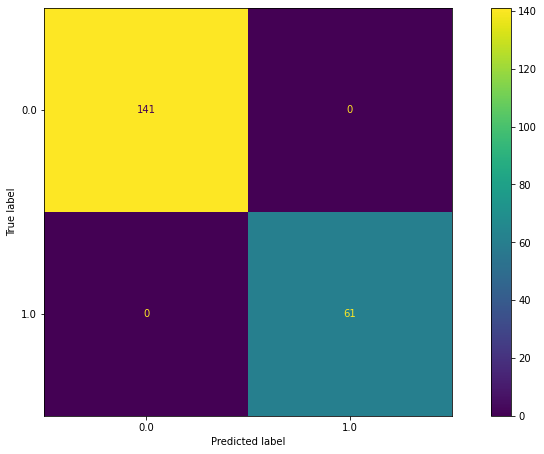

In [138]:
# Determining classification report for train set
print('Classification Score')
print(classification_report(y_train, y_pred_train_rf_default))

# Get F1 Score, Precision Score and Recall Score - Train Set
print('F1 Score (Train Set)  : ', f1_score(y_train, y_pred_train_rf_default))
print('Precision (Train Set) : ', precision_score(y_train, y_pred_train_rf_default))
print('Recall (Train Set)    : ', recall_score(y_train, y_pred_train_rf_default), '\n')
print('Accuracy (Train Set)  : ', accuracy_score(y_train, y_pred_train_rf_default), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Train Set')
cm = confusion_matrix(y_train, y_pred_train_rf_default, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)

disp.plot()
plt.show()

Classification Score
              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78        58
         1.0       0.33      0.07      0.11        29

    accuracy                           0.64        87
   macro avg       0.50      0.50      0.45        87
weighted avg       0.56      0.64      0.56        87

F1 Score (Test Set)  :  0.1142857142857143
Precision (Test Set) :  0.3333333333333333
Recall (Test Set)    :  0.06896551724137931 

Accuracy (Test Set)  :  0.6436781609195402 

Confusion Matrix Test Set


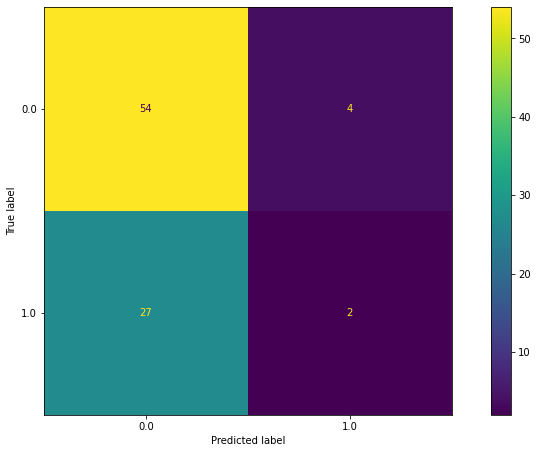

In [139]:
# Determining classification report for test set
print('Classification Score')
print(classification_report(y_test, y_pred_test_rf_default))

# Get F1 Score, Precision Score and Recall Score - test Set
print('F1 Score (Test Set)  : ', f1_score(y_test, y_pred_test_rf_default))
print('Precision (Test Set) : ', precision_score(y_test, y_pred_test_rf_default))
print('Recall (Test Set)    : ', recall_score(y_test, y_pred_test_rf_default), '\n')
print('Accuracy (Test Set)  : ', accuracy_score(y_test, y_pred_test_rf_default), '\n')

# Creating confusion matrix for test set
print('Confusion Matrix Test Set')
cm = confusion_matrix(y_test, y_pred_test_rf_default, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)

disp.plot()
plt.show()

There is a difference between Train and Test set based on the confusion matrix above, where test set does not have any perfect `accuracy` and `f1 score`. This can be indicated that the number of dataset is too little. However, we can conclude that the **Bagging (Random Forest Classifier) with default parameter is not a good model** to class `death_event` because of **its low accuracy and bias**.

#### **7.1.3. Hyperparameter Tuning**

Hyperparameter tuning will be using **GridSearchCV** because of its **exhaustive process** in searching the best hyperparameter and it is expected to have a better result than Manual or RandomSearch.

**Train Set Hyperparameter Tuning**

In [35]:
# Define Hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(3, 6, num = 4)]
min_samples_split = [2, 6, 10]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'criterion':['entropy','gini'],
               'bootstrap': bootstrap}
param_grid

{'n_estimators': [50, 62, 75, 87, 100],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_leaf': [3, 4, 5, 6],
 'criterion': ['entropy', 'gini'],
 'bootstrap': [True, False]}

In [36]:
# Train with Grid Search
%%time
rf_gridcv = GridSearchCV(rf,
                         param_grid,
                         n_jobs=4,
                         verbose=2,
                         scoring='f1')

rf_gridcv.fit(X_train_final, y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
CPU times: user 44 s, sys: 1.43 s, total: 45.4 s
Wall time: 12min 52s


GridSearchCV(estimator=RandomForestClassifier(random_state=3), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 4, 5, 6],
                         'n_estimators': [50, 62, 75, 87, 100]},
             scoring='f1', verbose=2)

In [140]:
# Showing best hyperparameters train set
rf_gridcv.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 87}

In [141]:
# Get Best Estimator
rf_gridcv_best = rf_gridcv.best_estimator_

We can see that the train set has the chosen hyperparameter as below:

```
 'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 87
 ```

 Apparently we do not need boostrap for this model. However, we should check it out its result without bootstrap later.

**Test set Hyperparameter Tuning**

In [39]:
# Train with Grid Search
%%time
rf_gridcv_test = GridSearchCV(rf,
                              param_grid,
                              n_jobs=4,
                              verbose=2,
                              scoring='f1')

rf_gridcv_test.fit(X_test_final, y_test)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
CPU times: user 43.7 s, sys: 1.54 s, total: 45.3 s
Wall time: 11min 45s


GridSearchCV(estimator=RandomForestClassifier(random_state=3), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 4, 5, 6],
                         'n_estimators': [50, 62, 75, 87, 100]},
             scoring='f1', verbose=2)

In [142]:
# Showing best hyperparameters test set
rf_gridcv_test.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'n_estimators': 87}

In [143]:
# Get Best Estimator
rf_gridcv_test_best = rf_gridcv_test.best_estimator_

The chosen hyperparameter for test set is as below:

```
 'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'n_estimators': 87
```

The difference between train and test hyperparameter tuning is just `min_samples_leaf`, which are 3 and 6 accordingly.

#### **7.1.4. Model Training with Hyperparameter Tuning**

In [144]:
# Predict the Train set results with tuned hyperparameter
y_pred_train_rf = rf_gridcv_best.predict(X_train_final)

# Predict the Test set results with tuned hyperparameter
y_pred_test_rf = rf_gridcv_test_best.predict(X_test_final)

print('Predicition Train:', '\n', y_pred_train_rf)
print('Predicition Test :', '\n', y_pred_test_rf)

Predicition Train: 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Predicition Test : 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### **7.2. Model Evaluation**

#### **7.2.1. Model Evaluation Train Set**

The confusion matrix and classification score for train set shows that **train set with hyperparameter tuning creates a better result** than the model with default parameters.

Although some classes are still resulting 100% such as **recall** `class-0` and **precision** `class-1`, this can be evaluated that **the hyperparamter tuning needs to be refined** to create less biased results.

*Confusion Matrix & Classification Score*

Accuracy - Train Set  :  0.9455445544554455 

F1 Score - Train Set  :  0.9009009009009009 

Classification Report : 
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       141
         1.0       1.00      0.82      0.90        61

    accuracy                           0.95       202
   macro avg       0.96      0.91      0.93       202
weighted avg       0.95      0.95      0.94       202
 

Confusion Matrix Train Set


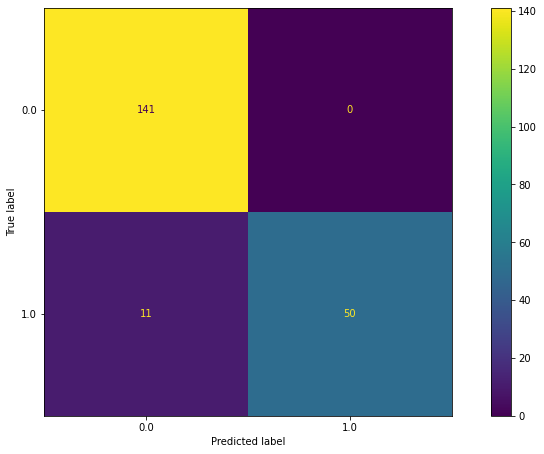

In [145]:
# Evaluating Train set with tuned hyperparameter
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_pred_train_rf), '\n')
print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train_rf), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train_rf), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Train Set')
cm = confusion_matrix(y_train, y_pred_train_rf, labels=rf_gridcv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_gridcv.classes_)

disp.plot()
plt.show()

#### **7.2.2. Model Evaluation Test Set**

Based on the confusion matrix and classification score for test set, we can see that **test set with hyperparameter tuning creates a better result** than the model with default parameters. However, for test set case, the model corrected the class, where finally **False Negative decreased** from `27` to `14`. This means, there are some incorrect results where people should have been included as `death` in actual situation, but the classification model tells us `non-death`.

The same treatment like train set hyperparameter tuned, the model needs to be refined as well.

*Confusion Matrix & Classification Score*

Accuracy - Test Set  :  0.8390804597701149 

F1 Score - Test Set  :  0.6818181818181819 

Classification Report : 
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.89        58
         1.0       1.00      0.52      0.68        29

    accuracy                           0.84        87
   macro avg       0.90      0.76      0.79        87
weighted avg       0.87      0.84      0.82        87
 

Confusion Matrix Test Set


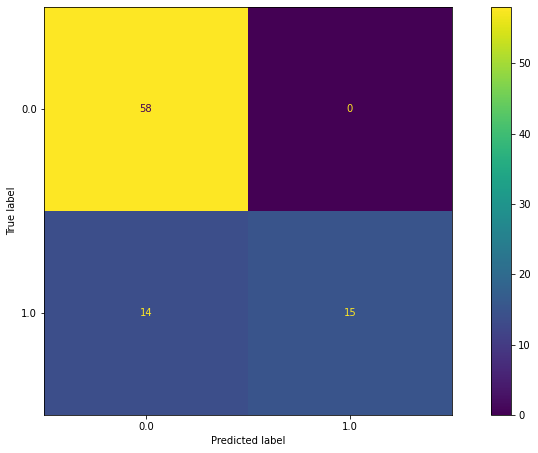

In [146]:
# Evaluating Train set with tuned hyperparameter
print('Accuracy - Test Set  : ', accuracy_score(y_test, y_pred_test_rf), '\n')
print('F1 Score - Test Set  : ', f1_score(y_test, y_pred_test_rf), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test_rf), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Test Set')
cm = confusion_matrix(y_test, y_pred_test_rf, labels=rf_gridcv_test_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_gridcv_test_best.classes_)

disp.plot()
plt.show()

## **8. AdaBoost Classifier**

In [147]:
# Fitting Random Forest Model with default parameter
abc.fit(X_train_final, y_train)

AdaBoostClassifier(random_state=3)

### **8.1. Model Training**

#### **8.1.1. Cross-Validation**

In [148]:
# Cross Validation using `cross_val_score` for train set default parameter
train_cross_val = cross_val_score(abc, 
                                  X_train_final, 
                                  y_train, 
                                  cv=5, 
                                  scoring='accuracy')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.58536585 0.53658537 0.55       0.575      0.675     ]
Mean - Cross-Validation               : 0.584390243902439
Standard Deviation Cross-Validation   : 0.048512372928833314


#### **8.1.2. Default Prediction**

In [149]:
# Predicting target with AdaBoostClassifier
y_pred_train_abc_default = abc.predict(X_train_final)
y_pred_test_abc_default = abc.predict(X_test_final)

The model with default parameters actually has a good score based on its `accuracy` and `f1-score`, which is not 100% perfectly classified for train set and test set.

Classification Score
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       141
         1.0       0.92      0.59      0.72        61

    accuracy                           0.86       202
   macro avg       0.88      0.78      0.81       202
weighted avg       0.87      0.86      0.85       202

F1 Score (Train Set)  :  0.7200000000000001
Precision (Train Set) :  0.9230769230769231
Recall (Train Set)    :  0.5901639344262295 

Accuracy (Train Set)  :  0.8613861386138614 

Confusion Matrix Train Set


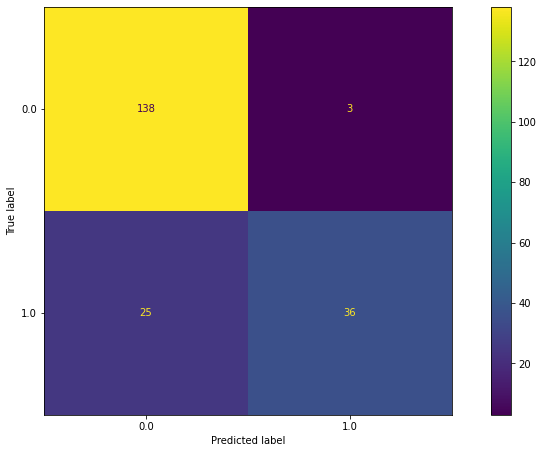

In [150]:
# Determining classification report for train set
print('Classification Score')
print(classification_report(y_train, y_pred_train_abc_default))

# Get F1 Score, Precision Score and Recall Score - Train Set
print('F1 Score (Train Set)  : ', f1_score(y_train, y_pred_train_abc_default))
print('Precision (Train Set) : ', precision_score(y_train, y_pred_train_abc_default))
print('Recall (Train Set)    : ', recall_score(y_train, y_pred_train_abc_default), '\n')
print('Accuracy (Train Set)  : ', accuracy_score(y_train, y_pred_train_abc_default), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Train Set')
cm = confusion_matrix(y_train, y_pred_train_abc_default, labels=abc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=abc.classes_)

disp.plot()
plt.show()

Classification Score
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78        58
         1.0       0.53      0.31      0.39        29

    accuracy                           0.68        87
   macro avg       0.62      0.59      0.59        87
weighted avg       0.65      0.68      0.65        87

F1 Score (Train Set)  :  0.391304347826087
Precision (Train Set) :  0.5294117647058824
Recall (Train Set)    :  0.3103448275862069 

Accuracy (Train Set)  :  0.6781609195402298 

Confusion Matrix Train Set


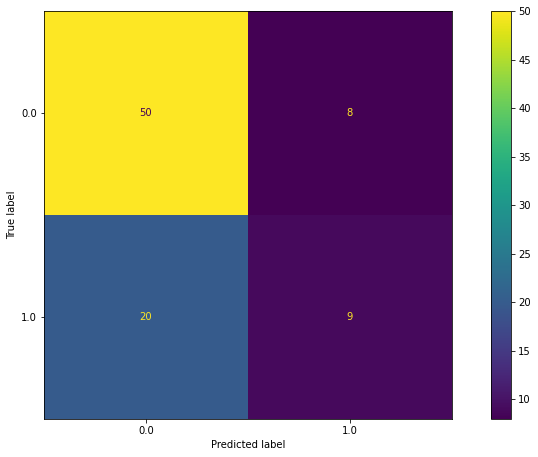

In [151]:
# Determining classification report for test set
print('Classification Score')
print(classification_report(y_test, y_pred_test_abc_default))

# Get F1 Score, Precision Score and Recall Score - Test Set
print('F1 Score (Train Set)  : ', f1_score(y_test, y_pred_test_abc_default))
print('Precision (Train Set) : ', precision_score(y_test, y_pred_test_abc_default))
print('Recall (Train Set)    : ', recall_score(y_test, y_pred_test_abc_default), '\n')
print('Accuracy (Train Set)  : ', accuracy_score(y_test, y_pred_test_abc_default), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Train Set')
cm = confusion_matrix(y_test, y_pred_test_abc_default, labels=abc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=abc.classes_)

disp.plot()
plt.show()

Meanwhile, test set with default parameter needs to be corrected as the model looks like not accurate, and that is also the reason why `f1 score` based on confusion matrix above is depleted. The hyperparemter tuning is obviously needed for this case.

#### **8.1.3. Hyperparameter Tuning**

Hyperparameter tuning for AdaBoostClassifier needs a base estimator, that the default is DecisionTreeClassifier. This `base estimator` is usually known as **Decision Stumps**. Decision Stumps are like trees in a Random Forest, but not "fully grown". They have one node and two leaves. AdaBoost uses a forest of such stumps rather than trees.

In [152]:
# Define Hyperparameters
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=3))

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
learning_rate = [(0.97 + x / 100) for x in range(0, 5)]

param_grid_abc = {'base_estimator__max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
                  'base_estimator__min_samples_leaf': [3,4,5],
                  'base_estimator__criterion': ['gini', 'entropy'],
                  'n_estimators':n_estimators,
                  'learning_rate':learning_rate,
                  'algorithm': ['SAMME', 'SAMME.R']}
param_grid_abc

{'base_estimator__max_depth': [10, 20, 30, 40, 50],
 'base_estimator__min_samples_leaf': [3, 4, 5],
 'base_estimator__criterion': ['gini', 'entropy'],
 'n_estimators': [10, 20, 30, 40, 50],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01],
 'algorithm': ['SAMME', 'SAMME.R']}

**Train set Hyperparameter Tuning**

The chosen hyperparemter is as below:

```
 'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 30,
 'base_estimator__min_samples_leaf': 4,
 'learning_rate': 0.99,
 'n_estimators': 10
 ```

 The weak classifier used is **DecisionTreeClassifier**, with criterion chosen is entropy and maximum depth of the tree is 30.

In [51]:
# Train with Grid Search
%%time
abc_gridcv = GridSearchCV(abc,
                          param_grid_abc,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')
abc_gridcv.fit(X_train_final, y_train)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
CPU times: user 25 s, sys: 811 ms, total: 25.8 s
Wall time: 7min 8s


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=3)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__max_depth': [10, 20, 30, 40, 50],
                         'base_estimator__min_samples_leaf': [3, 4, 5],
                         'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=2)

In [153]:
# Showing best hyperparameters train set
abc_gridcv.best_params_

{'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 30,
 'base_estimator__min_samples_leaf': 4,
 'learning_rate': 0.99,
 'n_estimators': 10}

In [154]:
# Get Best Estimator
abc_gridcv_best = abc_gridcv.best_estimator_

**Test set Hyperparameter Tuning**

The chosen hyperparemter is as below:

```
 'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 20,
 'base_estimator__min_samples_leaf': 5,
 'learning_rate': 0.99,
 'n_estimators': 10
 ```

 The weak classifier used is **DecisionTreeClassifier**, with criterion chosen is entropy and maximum depth of the tree is 20.

In [54]:
# Train with Grid Search
%%time
abc_gridcv_test = GridSearchCV(abc,
                          param_grid_abc,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')
abc_gridcv_test.fit(X_test_final, y_test)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
CPU times: user 24.4 s, sys: 776 ms, total: 25.2 s
Wall time: 6min 22s


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=3)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__max_depth': [10, 20, 30, 40, 50],
                         'base_estimator__min_samples_leaf': [3, 4, 5],
                         'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=2)

In [155]:
# Showing best hyperparameters train set
abc_gridcv_test.best_params_

{'algorithm': 'SAMME',
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 20,
 'base_estimator__min_samples_leaf': 5,
 'learning_rate': 0.99,
 'n_estimators': 10}

In [156]:
# Get Best Estimator
abc_gridcv_test_best = abc_gridcv_test.best_estimator_

#### **8.1.4. Model Training with Hyperparameter Tuning**

In [157]:
# Predict the Train set results with tuned hyperparameter
y_pred_train_abc = abc_gridcv_best.predict(X_train_final)

# Predict the Test set results with tuned hyperparameter
y_pred_test_abc = rf_gridcv_test_best.predict(X_test_final)

print('Predicition Train:', '\n', y_pred_train_abc)
print('Predicition Test :', '\n', y_pred_test_abc)

Predicition Train: 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
Predicition Test : 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### **8.2. Model Evaluation**

#### **8.2.1. Model Evaluation Train Set**

The confusion matrix and classification report show that apparently Adaptive Boost Classifier is too strong for Train Dataset to classify the prediction, which creates the classification is more biased. **The default parameter results look better than the model with hyperparameter tuning**.

This can be understood that basically Adaptive Boost Classifier has a better algorithm **to classify the model without biased results, however its variance needs to be corrected**.

Accuracy - Test Set  :  1.0 

F1 Score - Test Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00        61

    accuracy                           1.00       202
   macro avg       1.00      1.00      1.00       202
weighted avg       1.00      1.00      1.00       202
 

Confusion Matrix Test Set


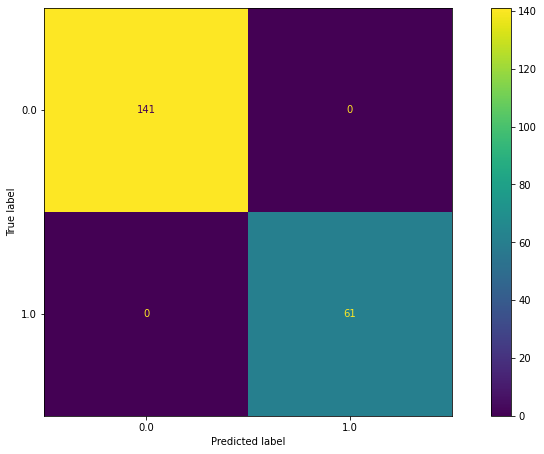

In [158]:
# Evaluating Train set with tuned hyperparameter
print('Accuracy - Test Set  : ', accuracy_score(y_train, y_pred_train_abc), '\n')
print('F1 Score - Test Set  : ', f1_score(y_train, y_pred_train_abc), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train_abc), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Test Set')
cm = confusion_matrix(y_train, y_pred_train_abc, labels=abc_gridcv_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=abc_gridcv_best.classes_)

disp.plot()
plt.show()

#### **8.2.2. Model Evaluation Test Set**

Meanwhile for test set with hyperparemeter tuning, the cofusion matrix and classification report show that the classification is actually much better than the model with default parameters. The same characteristic as Random Forest Classifier, **False Negative** based on the confusion matrix below is lower than the model with defaul parameter, from `25` to `14`.

Accuracy - Test Set  :  0.8390804597701149 

F1 Score - Test Set  :  0.6818181818181819 

Classification Report : 
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.89        58
         1.0       1.00      0.52      0.68        29

    accuracy                           0.84        87
   macro avg       0.90      0.76      0.79        87
weighted avg       0.87      0.84      0.82        87
 

Confusion Matrix Test Set


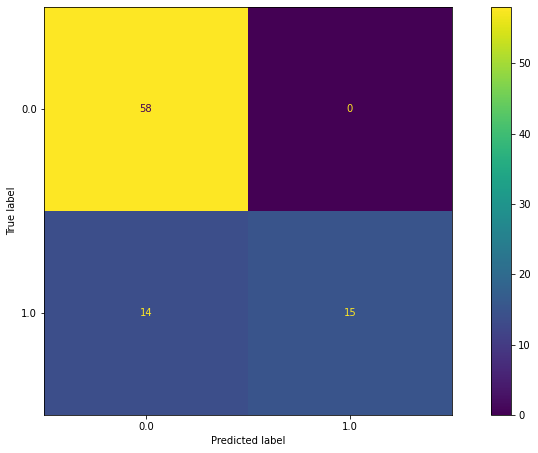

In [159]:
# Evaluating Train set with tuned hyperparameter
print('Accuracy - Test Set  : ', accuracy_score(y_test, y_pred_test_abc), '\n')
print('F1 Score - Test Set  : ', f1_score(y_test, y_pred_test_abc), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test_abc), '\n')

# Creating confusion matrix for train set
print('Confusion Matrix Test Set')
cm = confusion_matrix(y_test, y_pred_test_abc, labels=abc_gridcv_test_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=abc_gridcv_test_best.classes_)

disp.plot()
plt.show()

## **Overall Evaluation**

**Random Forest Classifier**

In [165]:
# Save Classification Report into a Dictionary

all_reports = {}
score_reports = {
    'train - precision' : precision_score(y_train, y_pred_train_rf_default),
    'train - recall' : recall_score(y_train, y_pred_train_rf_default),
    'train - accuracy' : accuracy_score(y_train, y_pred_train_rf_default),
    'train - f1_score' : f1_score(y_train, y_pred_train_rf_default),
    'test - precision' : precision_score(y_test, y_pred_test_rf_default),
    'test - recall' : recall_score(y_test, y_pred_test_rf_default),
    'test - accuracy' : accuracy_score(y_test, y_pred_test_rf_default),
    'test - f1_score' : f1_score(y_test, y_pred_test_rf_default),
}
all_reports['Baseline RF (Default)'] = score_reports
pd.DataFrame(all_reports)

,Baseline RF (Default)
test - accuracy,0.643678
test - f1_score,0.114286
test - precision,0.333333
test - recall,0.068966
train - accuracy,1.000000
train - f1_score,1.000000
train - precision,1.000000
train - recall,1.000000


In [166]:
score_reports = {
    'train - precision' : precision_score(y_train, y_pred_train_rf),
    'train - recall' : recall_score(y_train, y_pred_train_rf),
    'train - accuracy' : accuracy_score(y_train, y_pred_train_rf),
    'train - f1_score' : f1_score(y_train, y_pred_train_rf),
    'test - precision' : precision_score(y_test, y_pred_test_rf),
    'test - recall' : recall_score(y_test, y_pred_test_rf),
    'test - accuracy' : accuracy_score(y_test, y_pred_test_rf),
    'test - f1_score' : f1_score(y_test, y_pred_test_rf),
}
all_reports['RF Grid Search'] = score_reports

pd.DataFrame(all_reports).sort_index()

,Baseline RF (Default),RF Grid Search
test - accuracy,0.643678,0.839080
test - f1_score,0.114286,0.681818
test - precision,0.333333,1.000000
test - recall,0.068966,0.517241
train - accuracy,1.000000,0.945545
train - f1_score,1.000000,0.900901
train - precision,1.000000,1.000000
train - recall,1.000000,0.819672


The same analysis like in part `7.2. Model Evaluation`, we can see that the train set is perfect 100% accurate and test set is not accurate and even depleted. RF Grid Search column shows that the results of the model is getting better with hyperparemeter tuning. **This means that the hyperparameter tuning is useful to avoid overfitting.**

Moreover, the key takeaways from Random Forest Classifier is **a bagging technique that aims to decrease variance, but not bias**.

**AdaBoost Classifier**

In [167]:
# Save Classification Report into a Dictionary

all_reports = {}
score_reports = {
    'train - precision' : precision_score(y_train, y_pred_train_abc_default),
    'train - recall' : recall_score(y_train, y_pred_train_abc_default),
    'train - accuracy' : accuracy_score(y_train, y_pred_train_abc_default),
    'train - f1_score' : f1_score(y_train, y_pred_train_abc_default),
    'test - precision' : precision_score(y_test, y_pred_test_abc_default),
    'test - recall' : recall_score(y_test, y_pred_test_abc_default),
    'test - accuracy' : accuracy_score(y_test, y_pred_test_abc_default),
    'test - f1_score' : f1_score(y_test, y_pred_test_abc_default),
}
all_reports['Baseline ABC (Default)'] = score_reports
pd.DataFrame(all_reports)

,Baseline ABC (Default)
test - accuracy,0.678161
test - f1_score,0.391304
test - precision,0.529412
test - recall,0.310345
train - accuracy,0.861386
train - f1_score,0.720000
train - precision,0.923077
train - recall,0.590164


In [168]:
score_reports = {
    'train - precision' : precision_score(y_train, y_pred_train_abc),
    'train - recall' : recall_score(y_train, y_pred_train_abc),
    'train - accuracy' : accuracy_score(y_train, y_pred_train_abc),
    'train - f1_score' : f1_score(y_train, y_pred_train_abc),
    'test - precision' : precision_score(y_test, y_pred_test_abc),
    'test - recall' : recall_score(y_test, y_pred_test_abc),
    'test - accuracy' : accuracy_score(y_test, y_pred_test_abc),
    'test - f1_score' : f1_score(y_test, y_pred_test_abc),
}
all_reports['ABC Grid Search'] = score_reports

pd.DataFrame(all_reports).sort_index()

,Baseline ABC (Default),ABC Grid Search
test - accuracy,0.678161,0.839080
test - f1_score,0.391304,0.681818
test - precision,0.529412,1.000000
test - recall,0.310345,0.517241
train - accuracy,0.861386,1.000000
train - f1_score,0.720000,1.000000
train - precision,0.923077,1.000000
train - recall,0.590164,1.000000


Adaptive Boost Classifier is completely different from Random Forest Classifier. Adaptive Boost Classifier is a boosting technique. Boosting is a class of ensemble machine learning algorithms that involve combining the predictions from many weak learners, in this case for example, is Decision Tree Classifier with default paramters. The AdaBoost algorithm involves using very short (one-level) Decision Trees as weak learners that are added sequentially to the ensemble.

The key takeaways from Adaptive Boost Classifier (AdaBoost) is **a boosting technique that aims to decrease bias, but not variance**.

## **9. Model Inference**

### **9.1. Save and Load Model**

In [173]:
# Save the model files
with open('abc_gridcv.pkl', 'wb') as file_1:
  joblib.dump(abc_gridcv_best, file_1)

with open('rf_gridcv.pkl', 'wb') as file_2:
  joblib.dump(rf_gridcv_best, file_2)

with open('model_scaler.pkl', 'wb') as file_3:
  joblib.dump(scaler, file_3)

with open('num_columns.txt', 'w') as file_4:
  json.dump(num_columns, file_4)

with open('cat_columns.txt', 'w') as file_5:
  json.dump(cat_columns, file_5)

In [174]:
# Load all model files
with open('abc_gridcv.pkl', 'rb') as file_1:
  abc_model = joblib.load(file_1)

with open('abc_gridcv.pkl', 'rb') as file_2:
  rf_model = joblib.load(file_2)

with open('model_scaler.pkl', 'rb') as file_3:
  model_scaler = joblib.load(file_3)

with open('num_columns.txt', 'r') as file_4:
  num_columns = json.load(file_4)

with open('cat_columns.txt', 'r') as file_5:
  cat_columns = json.load(file_5)

### **9.2. Features Selection**

In [176]:
# Feature Scaling for data inference
df_inf_num = df_inf.drop(['death_event'],axis=1)

df_inf_scaled = model_scaler.transform(df_inf_num)
df_inf_scaled = pd.DataFrame(df_inf_scaled, columns = df_inf_num.columns, index = df_inf_num.index)
df_inf_scaled

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time
19,-0.296478,1.149713,-0.498912,-0.729076,-0.712364,-0.375362,0.771322,-1.174222
103,-0.541253,1.149713,-0.186652,2.754623,1.403776,7.227857,0.068433,0.848352
109,0.356258,-0.869783,-0.481099,-1.600001,-0.712364,-0.090241,-1.805938,-1.633898
115,-0.051702,-0.869783,-0.562831,-1.600001,-0.712364,1.430403,-2.274530,-0.885283
123,0.111482,-0.869783,-0.392031,-1.164539,1.403776,-0.470402,0.771322,-1.594497
204,0.193074,1.149713,-0.526156,-0.293614,-0.712364,-0.470402,-0.165863,1.820239
242,-0.459661,-0.869783,0.240871,0.141849,-0.712364,-0.660483,0.771322,0.204806
264,-0.459661,1.149713,-0.445472,0.577311,-0.712364,-0.204289,0.068433,1.045356
285,1.988096,-0.869783,-0.498912,1.883698,-0.712364,-0.185281,-1.103049,-0.543809
296,0.764217,-0.869783,-0.532444,1.883698,1.403776,-0.470402,0.302729,0.717016


### **9.3. Model Training Inference**

#### **9.3.1. Random Forest Classifier**

In [181]:
# Predict using RandomForestClassifier
y_pred_inf = rf_model.predict(df_inf_num)

# Create DataFrame
y_pred_inf_rf = pd.DataFrame(y_pred_inf, columns=['RF Predicted (Inference)'],index=df_inf_scaled.index)
y_pred_inf_rf

,RF Predicted (Inference)
19,0.0
103,0.0
109,0.0
115,0.0
123,0.0
204,0.0
242,0.0
264,0.0
285,0.0
296,0.0


In [182]:
# Comparing the real income bracket and predicted classification
model_inf = pd.concat([df_inf['death_event'], y_pred_inf_rf['RF Predicted (Inference)']], axis=1).sort_index()
model_inf

,death_event,RF Predicted (Inference)
19,1.0,0.0
103,1.0,0.0
109,1.0,0.0
115,1.0,0.0
123,1.0,0.0
204,0.0,0.0
242,0.0,0.0
264,0.0,0.0
285,1.0,0.0
296,0.0,0.0


#### **9.3.2. AdaBoostClassifier**

In [184]:
# Predict using RandomForestClassifier
y_pred_inf_abc = abc_model.predict(df_inf_num)

# Create DataFrame
y_pred_inf_abc = pd.DataFrame(y_pred_inf, columns=['ABC Predicted (Inference)'],index=df_inf_scaled.index)
y_pred_inf_abc

,ABC Predicted (Inference)
19,0.0
103,0.0
109,0.0
115,0.0
123,0.0
204,0.0
242,0.0
264,0.0
285,0.0
296,0.0


In [185]:
# Comparing the real income bracket and predicted classification
model_inf = pd.concat([df_inf['death_event'], y_pred_inf_abc['ABC Predicted (Inference)']], axis=1).sort_index()
model_inf

,death_event,ABC Predicted (Inference)
19,1.0,0.0
103,1.0,0.0
109,1.0,0.0
115,1.0,0.0
123,1.0,0.0
204,0.0,0.0
242,0.0,0.0
264,0.0,0.0
285,1.0,0.0
296,0.0,0.0


## **10. Conclusions**

We can conclude that the predicion of `death` because of heart failure is basically because of three things: `time`, `serum_creatine`, and `age` hold top three highest significance.

Meanwhile the lowest are `sex`, `diabetes`, `smoking`, and `platelets` are under p-value 0.05 threshold, which are not significant to influence the `death_event`

It should be remembered although `smoking` is famous of its potency to kill, but apparently heart failure is more about taking a short-time to kill the patient. Smoking could be the factors, but it is more like for a long-term death.

**The predicition** depends on the algorithm used, in this case, apparently using Boosting technique, such as **AdaBoostClassfier shows a better result without hyperparameter tuning**. However, **Random Forest Classifier is also good with hyperparameter tuning**.

### **Answering Conceptual Problems**
**Random forest is a bagging technique, not a boosting technique; and Adaptive Boost Classifier is a boosting technique, not a bagging technique**.

In boosting as the name suggests, one is learning from other which in turn boosts the learning. The trees in random forests are run in parallel. There is no interaction between these trees while building the trees. This boosting technique can be taken as an example: **Adaptive Boost Classifier**

As we can see that RandomForestClassifier is too strong for the dataset, thus, it creates a high biased classification.

Bagging is the simplest way of combining predictions that belong to the same type while Boosting is a way of combining predictions that belong to the different types.

**Key Takeaways for Ensable Learning Bagging vs Boosting:**

- Random Forest Classifier is a bagging technique that aims to decrease variance, but not for bias.
- Adaptive Boost Classifier (AdaBoost) is a boosting technique that aims to decrease bias, but not variance.
